# CoderGirl Data Science Mini Project Part 2
### *Heart Disease Model*

Monica Feisher

This project was prepared as part of the LaunchCode CoderGirl Data Science course (January 2020) using data from the [UCI Heart Disease Dataset](https://www.kaggle.com/ronitf/heart-disease-uci). 

### Models Used:

1. Logistic Regression
    <br>A. All Features; No Normalization
    <br>B. All Features; Normalized Data
    <br>C. 5 Feature Subset; No Normalization
    <br>D. 5 Feature Subset; Normalized Data
    <br>E. 7 Feature Subset; No Normalization
    <br>F. 8 Feature Subset; No Normalization
2. Ensemble Learning (Random Forest, AdaBoost, and Gradient Boosting)
3. K-Nearest Neighbors

### Conclusions:

Of the logistic regression models, the model using an 8-feature subset without normalization produced the highest accuracy score in predicting the presence of heart disease. Of the ensemble learning models, the random forest model produced the highest accuracy score. The K-nearest neighbors model, using all features and a K value of 7, produced a similar accuracy score and specificity to the best logistic regression model with slightly higher sensitivity. 

## Import libraries and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import metrics, preprocessing, tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# Load the data
df = pd.read_csv('heart.csv')

In [3]:
# Modify column names to make them easier to understand
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

## Dropping Duplicate Row and Outlier

In Part I of this project (Exploratory Data Analysis) I noted one duplicate row and one outlier with a cholesterol reading of 564. I dropped these 2 rows. There were no null values in the dataset.

In [4]:
# Identify and drop duplicate values
duplicateRowsDF = df[df.duplicated()]
print(duplicateRowsDF)

# Drop one of the duplicates
df.drop_duplicates(keep='first',inplace=True) 

     age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
164   38    1                2                     138          175   

     fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
164                    0         1                      173   

     exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
164                        0            0.0         2                  4   

     thalassemia  target  
164            2       1  


In [5]:
# Remove high cholesterol outlier
indexNames = df[df['cholesterol'] == 564 ].index
df.drop(indexNames, inplace=True)

## Feature Engineering 

As in Part I, I used one-hot encoding to create dummy variables for categorical variables like sex and fasting blood sugar in order to build the model.

In [6]:
# Create dummy variables for categorical variables
df = pd.get_dummies(df, drop_first=True)
df.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Since the numerical variables have very different ranges, I created a normalized dataframe (nd).

In [7]:
# Normalize numerical variables to fall in a scale from 0 to 1
saved_columns = df.columns
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(df)

# Create normalized dataframe (nd)
nd = pd.DataFrame(scaler.transform(df), index=df.index, columns=saved_columns)
nd.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,0.708333,1.0,1.000000,0.481132,0.367698,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.426117,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.268041,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.378007,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.783505,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


## Model #1: Logistic Regression

For my first model, I tried logistic regression with different feature subsets, with and without normalizing the data.

#### Logistic Regression Model A: No Normalization; All Features

In [8]:
# Replace target values with True and False
df['target'] = df['target'].replace(to_replace = [0, 1], value = [True, False])

In [9]:
# Set X and y columns
X = df.drop(columns=['target'])
y = df['target']

# Create train and test sets
r_state = 35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 

In [10]:
# Build logistic regression model
my_model = LogisticRegression(random_state=r_state)
my_model.fit(X_train, y_train)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=35, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# Preview model predictions
y_pred = my_model.predict(X_test)
y_pred

array([ True, False, False, False,  True,  True, False,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True])

In [12]:
# Convert to NumPy array
y_test.to_numpy()

array([ True, False,  True, False,  True,  True,  True,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True, False, False, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False,  True,
        True, False,  True, False,  True,  True,  True, False, False,
        True, False, False, False,  True,  True, False,  True, False,
       False, False, False,  True, False, False, False,  True, False,
       False,  True,  True,  True,  True, False, False,  True, False,
       False,  True,  True, False,  True, False,  True, False,  True,
        True])

In [13]:
# Determine model score
my_model.score(X_test,y_test)

0.8

The baseline model, which included all features and does not include normalization, gave a model score of 0.8.

#### Logistic Regression Model B: Normalized Data; All Features

Model B incorporated all features, but used the normalized version of the dataframe (nd instead of df).

In [14]:
# Replace target values with True and False
nd['target'] = nd['target'].replace(to_replace = [0, 1], value = [True, False])

# Set X and y columns
X = nd.drop(columns=['target'])
y = nd['target']

# Create train and test sets
r_state = 35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 

# Build logistic regression model
my_model = LogisticRegression(random_state=r_state)
my_model.fit(X_train, y_train)

# Preview model predictions
y_pred = my_model.predict(X_test)
y_pred

# Convert to NumPy array
y_test.to_numpy()

# Determine model score
my_model.score(X_test,y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.82

Normalizing the dataframe resulted in a slight improvement in the model score, from 0.8 to 0.82.

#### Logistic Regression Model C: No Normalization; Subset of 5 Features

In Part I, I learned that the top 5 most strongly correlated features to target are chest pain type, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, and number of major vessels (0-3) colored by flourosopy. Next, I tried another model with a subset of those 5 features.

In [15]:
# Subset of top 5 most strongly correlated features
columns5 = ['chest_pain_type', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'num_major_vessels']
subset5 = df[columns5]
subset5.head()

,chest_pain_type,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels
0,3,150,0,2.3,0
1,2,187,0,3.5,0
2,1,172,0,1.4,0
3,1,178,0,0.8,0
4,0,163,1,0.6,0


In [16]:
# Training the new model
X = subset5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
sub_model = LogisticRegression(random_state=r_state)
sub_model.fit(X_train, y_train)
y_pred = sub_model.predict(X_test)
sub_model.score(X_test,y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.81

Model C, with a subset of 5 features, resulted in a slight increase in the model score over Model A, but still scored slightly lower than Model B (normalized data and all features).

#### Logistic Regression Model D: Normalized Data; Subset of 5 Features

In [17]:
# Subset of top 5 most strongly correlated features
columns5 = ['chest_pain_type', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'num_major_vessels']
subset_nd = nd[columns5]
subset_nd.head()

,chest_pain_type,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels
0,1.000000,0.603053,0.0,0.370968,0.0
1,0.666667,0.885496,0.0,0.564516,0.0
2,0.333333,0.770992,0.0,0.225806,0.0
3,0.333333,0.816794,0.0,0.129032,0.0
4,0.000000,0.702290,1.0,0.096774,0.0


In [18]:
# Training the new model
X = subset_nd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
sub_model = LogisticRegression(random_state=r_state)
sub_model.fit(X_train, y_train)
y_pred = sub_model.predict(X_test)
sub_model.score(X_test,y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.77

This model was the worst-performing of all the logistic regression models with a model score of 0.77. 

#### Logistic Regression Model E: No Normalization; Subset of 7 Features

The two previous models, with a subset of 5 features, showed minimal improvement over the model that included all features. There are 2 additional features, ST slope and Thalassemia, with correlations of at least +/- 0.3 to the target. Next, I tried one more version that includes the 7 most strongly correlated features.

In [19]:
# Adding ST slope and Thalassemia
columns7 = ['chest_pain_type', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'num_major_vessels', 'st_slope', 'thalassemia']
subset7 = df[columns7]

# Training the new model
X = subset7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
sub_model = LogisticRegression(random_state=r_state)
sub_model.fit(X_train, y_train)
y_pred = sub_model.predict(X_test)
sub_model.score(X_test,y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.84

Adding those features resulted in another small increase in the model score (0.84). The normalized version of this model had a lower score (0.78), so I did not include it in this notebook.

#### Logistic Regression Model F: No Normalization; Subset of 8 Features

Since adding those two variables resulted in a small increase in the score for Model E, I experimented with adding one of the remaining variables and found that the strongest model included age.

In [20]:
columns8 = ['age', 'chest_pain_type', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'num_major_vessels', 'st_slope', 'thalassemia']
subset8 = df[columns8]

# Training the new model
X = subset8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
sub_model = LogisticRegression(random_state=r_state)
sub_model.fit(X_train, y_train)
y_pred = sub_model.predict(X_test)
sub_model.score(X_test,y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.85

With the addition of age, the model score increased to 0.85. As before, the normalized version of this model had a lower score (0.78), so I did not include it in this notebook.

Since Model F had the highest model score of the logistic regression models, I completed additional assessment.

In [21]:
# Use a confusion matrix to assess the fit
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[51,  4],
       [11, 34]])

In [22]:
# Calculate sensitivity and specificity
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8225806451612904
Specificity :  0.8947368421052632


**Conclusion**: With a model score of 0.85, the strongest logistic regression model was Model F, which uses a subset of 8 features and does not normalize the data.

With a sensitivity of approximately 82%, Model F will correctly indicate **heart disease** in 82% of people who truly have heart disease (false negative rate of ~18%). With a specificity of approximately 89%, this model will correctly indicate **no heart disease** in 89% of people who do not have heart disease (false positive rate of ~11%).

## Model #2: Ensemble Learning

For our next set of models, I tried several ensemble learning models that use bagging and boosting to improve model accuracy: Random Forest, AdaBoost, and Gradient Boosting. Since our previous logistic regression model performed the best with a subset of the 8 most strongly correlated features, I will use the same subset for these models.

In [44]:
# Fit a Decision Tree model
X = subset8

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
accuracy_score(y_test, y_pred)

0.74

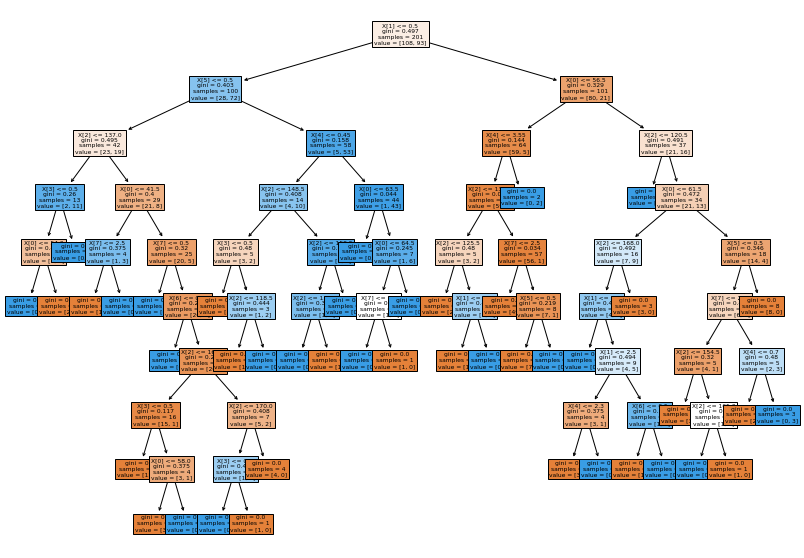

In [24]:
#Show the tree structure of the model
plt.figure(figsize=(14, 10))
clf = DecisionTreeClassifier().fit(X_train, y_train)
plot_tree(clf, filled=True, fontsize=6)
plt.show()

In [45]:
# Fit a Random Forest model
X = subset8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8

After running the models several times, I found that fitting a Random Forest model increases the accuracy of the model by about 5-9% over the Decision Tree model.

In [46]:
# Fit an AdaBoost model
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
accuracy_score(y_test, y_pred)

0.78

The AdaBoost model produced a slightly lower accuracy score compared to the Random Forest.

In [47]:
# Fit a Gradient Boosting model
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.78

The Gradient Boosting model also produced a slightly lower accuracy score than the Random Forest model.

#### Further Assessment of the Random Forest Model

Since the Random Forest model produced consistently better accuracy scores than my other ensemble learning models, I will complete further assessment.

In [48]:
# Recreating the Random Forest model
X = subset8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state) 
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8

In [49]:
# View classification report for the Random Forest model:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.91      0.77      0.83        65
        True       0.67      0.86      0.75        35

    accuracy                           0.80       100
   macro avg       0.79      0.81      0.79       100
weighted avg       0.82      0.80      0.80       100



In [30]:
# Use a confusion matrix to assess the fit
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[50,  5],
       [14, 31]])

In [50]:
# Calculate sensitivity and specificity
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8235294117647058
Specificity :  0.7777777777777778


**Conclusion**: 

Although the random forest model was the strongest of the ensemble learning models, it is less accurate than our strongest logistic regression model on every measure. The random forest model produces an accuracy score of 0.8. 

Sensitivity and specificity will vary each time I run the model, but the random forest model consistently shows sensitivity of ~77% and specificity of ~83%. With a sensitivity of approximately 77%, Model F will correctly indicate **heart disease** in 77% of people who truly have heart disease (false negative rate of ~27%). With a specificity of approximately 83%, this model will correctly indicate **no heart disease** in 83% of people who do not have heart disease (false positive rate of ~17%).

## Model #3: K-Nearest Neighbors

For the final model, I created a K-nearest neighbors model. After testing different subsets of features as I did with the logistic regression models, I found that this model performed best when all features were included.

In [84]:
# Set X and y columns
X = df.drop(columns=['target'])
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state)

# Scale dataset
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
# Initialize KNeighborsClassifier with an initial K value of 5 neighbors
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [86]:
# Make predictions
y_pred = classifier.predict(X_test)

In [87]:
# View classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.95      0.85        55
        True       0.91      0.64      0.75        45

    accuracy                           0.81       100
   macro avg       0.84      0.79      0.80       100
weighted avg       0.83      0.81      0.80       100



In [88]:
# Use a confusion matrix to assess the fit
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[52,  3],
       [16, 29]])

In [89]:
# Calculate sensitivity and specificity
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.7647058823529411
Specificity :  0.90625


I used an initial K value of 5 neighbors. After creating the intiial model, I plotted the mean errors for K values between 1 and 40 to see if there was a more ideal K value for this dataset.

In [90]:
accuracy_score(y_test, y_pred)

0.81

In [91]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

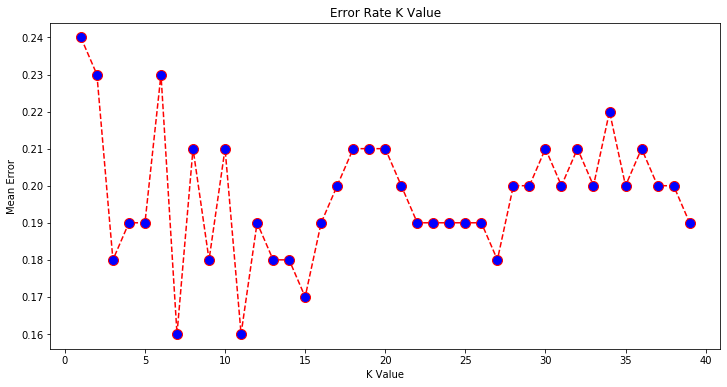

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Although the plot looked different each time I ran the model, I tested it multiple times and noticed that the mean error was most consistently lowest for a K value of 7. Since 7 seemed to be our ideal value for this model, I'll create another K-Nearest Neighbors model using 7 neighbors.

In [93]:
from sklearn.metrics import confusion_matrix

classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.95      0.87        55
        True       0.91      0.71      0.80        45

    accuracy                           0.84       100
   macro avg       0.86      0.83      0.83       100
weighted avg       0.85      0.84      0.84       100



In [96]:
accuracy_score(y_test, y_pred)

0.84

In [97]:
# Use a confusion matrix to assess the fit
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[52,  3],
       [13, 32]])

In [98]:
# Calculate sensitivity and specificity
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8
Specificity :  0.9142857142857143


##### **Conclusion**: 

Although the accuracy will vary each time I run the model, the K-nearest neighbors model consistently showed accuracy scores of approximately 0.85. With an accuracy score of ~0.85, the K-nearest neighbors model performs similarly to the best logistic regression model (Model F) in terms of accuracy. With a sensitivity of approximately 80%, it will correctly indicate **heart disease** in 80% of people who truly have heart disease (false negative rate of ~20%). With a specificity of approximately 91%, this model will correctly indicate **no heart disease** in 91% of people who do not have heart disease (false positive rate of ~9%). It ties the logistic regression model in terms of accuracy and sensitivity and performs slightly better in terms of specificity. 